In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import os
import gc
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
_ = files.upload()

Saving SO2.zip to SO2.zip


In [3]:
!unzip SO2.zip -d "SO2"
from IPython.display import clear_output
clear_output(wait=False)
!rm SO2.zip

In [4]:
files = pd.read_csv("/content/SO2/SO2/files.csv")

In [5]:
files.drop("Fold",axis=1,inplace=True)

In [6]:
files

,Date,SatFile,GroundFile,AltGrid
0,2021-01-25,sat_2021-01-25.npy,g_2021-01-25.npy,alt_2021-01-25.npy
1,2021-02-21,sat_2021-02-21.npy,g_2021-02-21.npy,alt_2021-02-21.npy
2,2020-01-06,sat_2020-01-06.npy,g_2020-01-06.npy,alt_2020-01-06.npy
3,2021-01-07,sat_2021-01-07.npy,g_2021-01-07.npy,alt_2021-01-07.npy
4,2021-02-07,sat_2021-02-07.npy,g_2021-02-07.npy,alt_2021-02-07.npy
...,...,...,...,...
480,2020-04-08,sat_2020-04-08.npy,g_2020-04-08.npy,alt_2020-04-08.npy
481,2021-04-23,sat_2021-04-23.npy,g_2021-04-23.npy,alt_2021-04-23.npy
482,2020-11-20,sat_2020-11-20.npy,g_2020-11-20.npy,alt_2020-11-20.npy
483,2021-01-19,sat_2021-01-19.npy,g_2021-01-19.npy,alt_2021-01-19.npy


In [7]:
def pearson(y_true,y_pred):
  if len(y_true.shape)!=1:
    true = []
    for i in range(y_true.shape[0]):
      true.extend(y_true[i])
    pred = []
    for i in range(y_pred.shape[0]):
      pred.extend(y_pred[i])
  else:
    true=y_true
    pred=y_pred
  return np.mean((np.array(true)-np.mean(true))*(np.array(pred)-np.mean(pred)))/(np.std(np.array(true))*np.std(np.array(pred)))

def pearsonCorrAvgDays(true, pred):
    assert true.shape == pred.shape, "true and pred must have the same shape, found {} and {}".format(true.shape, pred.shape)
    scores = []
    for i in range(true.shape[0]):
        scores.append(np.corrcoef(true[i], pred[i])[0, 1])
    return np.mean(scores), scores

def pearsonCorrAvgPixels(true,pred):
  scores = []
  for i in range(true.shape[1]):
    scores.append(pearson(true[:,i],pred[:,i]))
  return np.mean(scores),scores

In [8]:
def loadData(df,satdir = "/content/SO2/SO2/satellite/",gdir = "/content/SO2/SO2/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [9]:
!pip install torch
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00


In [10]:
#Build the model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Resize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torchvision.models import vision_transformer
from vit_pytorch import ViT
from math import ceil

def build_model(X_train):
    #print(X_train.shape)
    # Calculate the image size and channels
    patch_size = 16  # Choose an appropriate patch size
    channels = X_train.shape[-1]
    #print("channels",channels)
    #desired_height = 48
    #desired_width = 48
    #transform = Resize((desired_height, desired_width))
    #X_train_transformed = transform(X_train)

    image_height = X_train.shape[1]  # Use the transformed image height
    image_width = X_train.shape[2]  # Use the transformed image width

    # Adjust the desired height and width to be divisible by the patch size
    resized_height = patch_size * (image_height // patch_size)
    resized_width = patch_size * (image_width // patch_size)

    assert resized_height > 0 and resized_width > 0, "Image dimensions are too small."

    model = ViT(
        image_size=(resized_height, resized_width),
        patch_size=patch_size,
        num_classes=3776,
        dim=64,
        depth=12,
        heads=8,
        mlp_dim=128,
        channels=channels
    )

    # Define the loss function
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    return model, criterion, optimizer

In [11]:
def DataOfFractionSize(df,fraction,n_folds):
  df = df.reset_index(drop=True)
  mask = [False for _ in range(len(df))]

  indices = np.random.choice(list(df.index),int(len(df)*fraction),replace=False)
  for index in indices:
    mask[index]=True
  df = df.loc[mask,:].reset_index(drop=True)

  kf = KFold(n_splits = n_folds,shuffle=True)
  df.loc[:,'Fold'] = -1
  for idx,(trn_,val_) in enumerate(kf.split(df)):
    df.loc[val_,'Fold'] = idx

  return df

In [12]:
import warnings
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import SGD
from vit_pytorch import ViT
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, ColorJitter
from torchvision import transforms

def trainFunction(df,n_folds):
  # Model training
  scores_list = []
  rmses = []
  patch_size = 16
  warnings.filterwarnings("ignore", category=UserWarning)

  for fold in range(n_folds):
      train_files = df[df["Fold"]!=fold]
      val_files = df[df["Fold"]==fold]

      X_train,Y_train = loadData(train_files)
      X_val,Y_val = loadData(val_files)
      X_train_tensor = torch.from_numpy(X_train)  # Convert X_train to a PyTorch tensor

      desired_height = 64
      desired_width = 48

      # Data augmentation
      transform = transforms.Compose([
          RandomCrop((desired_height, desired_width)),
          RandomHorizontalFlip(),
          ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
          Resize((desired_height, desired_width))
      ])

      X_train = transform(torch.Tensor(X_train).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
      X_val = transform(torch.Tensor(X_val).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
      X_train_tensor = transform(X_train_tensor.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

      model, criterion, optimizer = build_model(X_train_tensor)
      optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)  # Example of using SGD optimizer

      if fold == 0:
          #print(model)
          pass

      train_dataset = torch.utils.data.TensorDataset(X_train.permute(0, 3, 1, 2), torch.Tensor(Y_train))
      val_dataset = torch.utils.data.TensorDataset(X_val.permute(0, 3, 1, 2), torch.Tensor(Y_val))

      train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=8)

      patience = 5  # Number of epochs to wait for improvement
      best_val_loss = np.inf
      num_epochs_without_improvement = 0

      # Learning rate scheduler
      lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

      for epoch in range(30):
          model.train()
          epoch_train_losses = []
          for inputs, targets in train_loader:
              optimizer.zero_grad()

              resized_inputs = inputs.clone()
              resized_inputs[:, :, :desired_height, :desired_width] = transform(inputs[:, :, :desired_height, :desired_width])

              resized_width = patch_size * (resized_inputs.shape[3] // patch_size)
              resized_inputs = resized_inputs[:, :, :, :resized_width]

              outputs = model(resized_inputs)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()

              epoch_train_losses.append(loss.item())

          model.eval()
          with torch.no_grad():
              val_outputs = []
              for inputs, targets in val_loader:
                  outputs = model(inputs)
                  val_outputs.append(outputs)
              val_outputs = torch.cat(val_outputs, dim=0)

          rmse = mean_squared_error(Y_val, val_outputs, squared=False)



          # Update learning rate
          lr_scheduler.step(rmse)

          # Check for early stopping
          if rmse < best_val_loss:
              best_val_loss = rmse
              num_epochs_without_improvement = 0
          else:
              num_epochs_without_improvement += 1
              if num_epochs_without_improvement == patience:
                  #print("Early stopping criteria met. Stopping training.")
                  break

      rmse1 = mean_squared_error(Y_val, val_outputs, squared=False)
      rmses.append(rmse1)
      #mae = mean_absolute_error(Y_val, val_outputs)
      #maes.append(mae)

      #print("Fold {} RMSE Score: {}".format(fold, rmse))
      #print("Fold {} MAE Score: {}".format(fold, mae))
      del model
      _ = gc.collect()

  print("\nCV RMSE Score: {}".format(np.mean(rmses)))
  return np.mean(rmses)

In [13]:
EXP_PER_SIZE = 20
N_FOLDS = 3
FRACTIONS = np.arange(0.1,1.1,0.1)

In [14]:
frac_vs_rmse = {}
for frac in FRACTIONS:
  print("\nTraining for {} % Dataset\n".format(int(frac*100)))
  exp_rmses = []
  for idx in range(EXP_PER_SIZE):
    print(f"Exp {idx+1}")
    exp_df = DataOfFractionSize(files,frac,N_FOLDS)
    exp_rmses.append(trainFunction(exp_df,N_FOLDS))
  frac_vs_rmse[frac] = exp_rmses


Training for 10 % Dataset

Exp 1
Epoch 00025: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00019: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00029: reducing learning rate of group 0 to 1.0000e-03.

CV RMSE Score: 5.630402607474086
Exp 2
Epoch 00024: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00024: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00029: reducing learning rate of group 0 to 1.0000e-03.

CV RMSE Score: 4.09406054676026
Exp 3
Epoch 00028: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00025: reducing learning rate of group 0 to 1.0000e-03.

CV RMSE Score: 3.607686277562276
Exp 4
Epoch 00018: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00028: reducing learning rate of group 0 to 1.0000e-03.

CV RMSE Score: 4.575401591119703
Exp 5
Epoch 00024: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00030: reducing learning rate of group 0 to 1.0000e-03.

CV RMSE Score: 3.6955076235240365
Exp 6
Epoch 00026: reducing 

In [15]:
p_data = []
scores = []
for p in FRACTIONS:
  score_ls = frac_vs_rmse[p]
  p_data.extend([int(p*100) for _ in range(len(score_ls))])
  scores.extend(score_ls)
results = pd.DataFrame({"Percentage of Data":p_data,"RMSE Scores":scores})

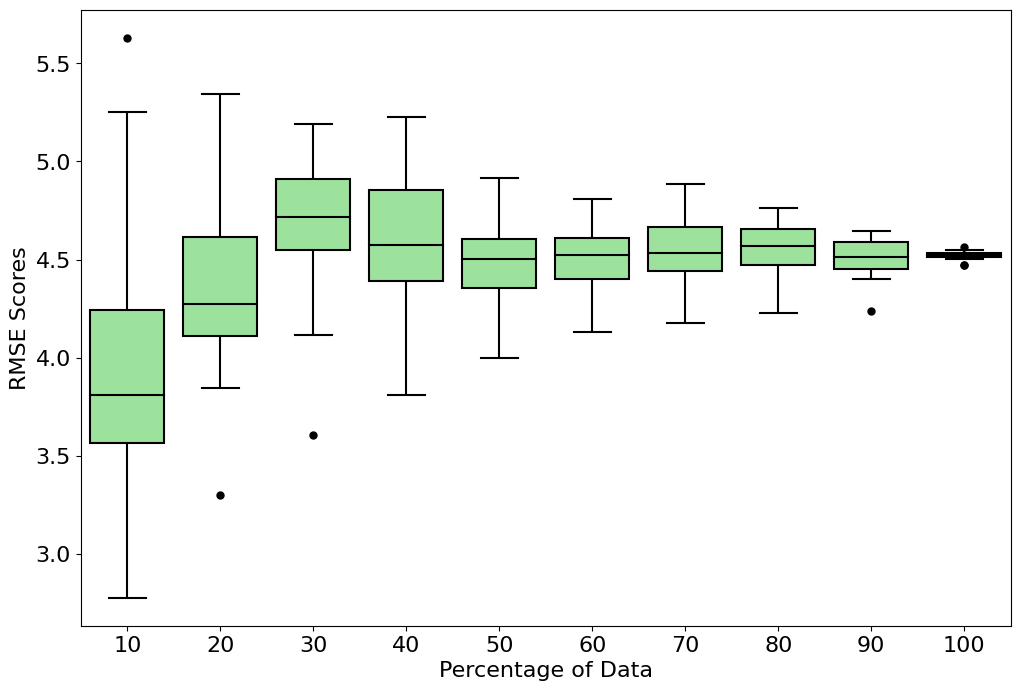

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 16

fig = plt.figure(figsize=(12, 8))

boxprops = dict(linewidth=1.5, edgecolor='black')
whiskerprops = dict(linewidth=1.5, color='black', solid_capstyle='butt')
capprops = dict(linewidth=1.5, color='black')
medianprops = dict(linewidth=1.5, color='black')
flierprops = dict(marker='o', markersize=5, markerfacecolor='black', markeredgecolor='black')

sns.boxplot(x='Percentage of Data', y='RMSE Scores', data=results, color="lightgreen",
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
            medianprops=medianprops, flierprops=flierprops)

plt.show()

In [17]:
fig.savefig("SO2_rmse_data.pdf")

In [19]:
for p in results["Percentage of Data"].unique():
  print("Percentage: ",p)
  temp_df = results[results["Percentage of Data"]==p]
  print("Mean: ",np.mean(temp_df["RMSE Scores"]))
  print("IQR: ",np.percentile(temp_df["RMSE Scores"], 75, interpolation = 'midpoint')-np.percentile(temp_df["RMSE Scores"], 25, interpolation = 'midpoint'))
  print('')

Percentage:  10
Mean:  3.9547272318854234
IQR:  0.8285118131081877

Percentage:  20
Mean:  4.354330295874101
IQR:  0.5337691298662168

Percentage:  30
Mean:  4.658590667786047
IQR:  0.42290138135866506

Percentage:  40
Mean:  4.5684287361345435
IQR:  0.5146956998196703

Percentage:  50
Mean:  4.470534306747327
IQR:  0.2635644321038457

Percentage:  60
Mean:  4.5175734783002515
IQR:  0.21894277070318147

Percentage:  70
Mean:  4.538844131595529
IQR:  0.25255668170181433

Percentage:  80
Mean:  4.545835024895485
IQR:  0.1944474711626647

Percentage:  90
Mean:  4.508336340699474
IQR:  0.13788894987281797

Percentage:  100
Mean:  4.521950796770872
IQR:  0.020402238664036787



<ipython-input-19-f19d56ffa7b3>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  print("IQR: ",np.percentile(temp_df["RMSE Scores"], 75, interpolation = 'midpoint')-np.percentile(temp_df["RMSE Scores"], 25, interpolation = 'midpoint'))
